In [66]:
import pandas as pd
import numpy as np
import re
import random
import copy
import geopandas as gpd

In [159]:
df=pd.read_csv("clustering_data.csv",dtype={"CircleName":str,"RegionName":str, #Types specified as it is memory-exhaustive for pandas to determine each type
                                            "DivisionName":str,"OfficeName":str,
                                            "Pincode":int,"OfficeType":str,"Delivery":str,
                                            "District":str,"StateName":str,"Latitude":str,"Longitude":str})
df=df[df['StateName']=="KARNATAKA"]
df=df[(df['Latitude'].notna()) | (df['Longitude'].notna())] #Removes entries where either latitude or longitude or both have missing values
pd.options.mode.chained_assignment = None  # to remove the warning for copying data below
df['LATITUDE']=0.0
df['LONGITUDE']=0.0
for num in df.index:
    df.loc[num,'LATITUDE']=float((re.findall("[\d.]*",df.loc[num,'Latitude']))[0])
    df.loc[num,'LONGITUDE']=float((re.findall("[\d.]*",df.loc[num,'Longitude']))[0])
del df['Latitude'],df['Longitude']
#df=df.assign(LATITUDE=float((re.findall("[\d.]*",df['Latitude']))[0]))
#8396
df=df.drop_duplicates()#No duplicates but an important preprocessing step nonetheless

In [161]:
#More Preprocessing on the basis of whether given coordinates fall withing the rough area of Karnataka
df=df[(df['LATITUDE']>11)&(df['LATITUDE']<19)]
df=df[(74<df['LONGITUDE']) & (df['LONGITUDE']<79)]
df

,CircleName,RegionName,DivisionName,OfficeName,Pincode,OfficeType,Delivery,District,StateName,LATITUDE,LONGITUDE
429,Karnataka Circle,North Karnataka Region,Bidar Division,MANHALLI S.O,585447,PO,Delivery,BIDAR,KARNATAKA,17.815500,76.797100
430,Karnataka Circle,North Karnataka Region,Bidar Division,Aliabad B.O,585404,BO,Delivery,BIDAR,KARNATAKA,17.625800,78.595500
1202,Karnataka Circle,South Karnataka Region,Mangaluru Division,Bajal S.O,575009,PO,Delivery,DAKSHINA KANNADA,KARNATAKA,12.853372,74.878526
9790,Karnataka Circle,South Karnataka Region,Hassan Division,Aggunda B.O,573103,BO,Delivery,HASSAN,KARNATAKA,13.320000,76.270000
9791,Karnataka Circle,South Karnataka Region,Hassan Division,Amaragiri Tirupathi B.O,573103,BO,Delivery,HASSAN,KARNATAKA,13.330000,76.270000
...,...,...,...,...,...,...,...,...,...,...,...
156499,Karnataka Circle,North Karnataka Region,Dharwad Division,Hubballi Bengeri S.O,580023,PO,Non Delivery,DHARWAD,KARNATAKA,15.369069,75.145737
156500,Karnataka Circle,North Karnataka Region,Dharwad Division,Hubballi Eng College S.O,580031,PO,Delivery,DHARWAD,KARNATAKA,15.368268,75.122869
156501,Karnataka Circle,North Karnataka Region,Dharwad Division,Hubballi Keshwapur S.O,580023,PO,Delivery,DHARWAD,KARNATAKA,15.361910,75.151495
156502,Karnataka Circle,North Karnataka Region,Dharwad Division,Hubballi Sarafkatta S.O,580020,PO,Non Delivery,DHARWAD,KARNATAKA,15.340767,75.143347


In [163]:
latt,long=df['LATITUDE'],df['LONGITUDE']
coords={}
for num in df.index: #Putting values into a dictionary per single coordinate
    coords[num]=[float(latt.loc[num]),float(long.loc[num])]
#print(coords.values())

In [165]:
#Defining a function to calculate euclidean distance between two points
def dist(coords1,coords2):
    return ((((coords1[0]-coords2[0])**2)+((coords1[1]-coords2[1])**2))**(1/2))

In [167]:
#Function to decide whether to stop running K means algorithm
#Technically doesn't account for the extremely unlikely case that in two iterations, the order of the cluster within the list may be different
def check(a,b,k):
    for i in range(k):
        if sorted(a[i])!=sorted(b[i]): #actually need not be sorted but nevertheless
            return False
    return True

In [115]:
#Function to perform K Means Clustering
def k_means(k):  
    #Both silhouette score parameters
    variance=0 #Variable to store variance of each point from the centre of the cluster
    #Variables to store previous iteration results to compare with current iteration to
    prev_iter_clust=[]
    for run in range(k):#Generating as many cluster lists as k
        prev_iter_clust.append([])
    prev_iter_cents=[]
    while True: #Filling centroids for first run with random elements from the DataFrame
        temp=random.choice(df.index)
        if coords[temp] in prev_iter_cents:
            continue
        else:
            prev_iter_cents.append(coords[temp])
        if len(prev_iter_cents)==k:
            break
    for element in df.index: #Assigning coordinates to the list
        dists=[]
        #print(coords[element])
        for run in range(k):
            dists.append(dist(coords[element],prev_iter_cents[run]))
        prev_iter_clust[dists.index(min(dists))].append(coords[element])
        variance+=min(dists)
        #print(dists,dists.index(min(dists)))
    curr_iter_cents=[] #Initialising a list to hold values for current iteration centroids
    for run in range(k): #Loop to get centroids for the current iteration
        lat_sum,lon_sum=0,0 #Initialising variables to help find centroids
        for elem in prev_iter_clust[run]:
            lat_sum+=elem[0]
            lon_sum+=elem[1]
        curr_iter_cents.append([lat_sum/len(prev_iter_clust[run]),lon_sum/len(prev_iter_clust[run])])
    prev_iter_cents=copy.deepcopy(curr_iter_cents)
    #print(prev_iter_clust)
    #print(prev_iter_cents,curr_iter_cents)
    #curr_iter_clust=copy.deepcopy(prev_iter_clust)
    #print(prev_iter_clust,prev_iter_cents,sep='\n')
    #print(sorted(prev_iter_clust)[0])
    runs=1
    '''if check(prev_iter_clust,curr_iter_clust): Code technically does not account for the possibility that the initial random points could be final centroids
        return
    else:
        prev_iter_clust=copy.deepcopy(prev_iter_clust)'''
    while True:
        variance=0
        runs+=1
        curr_iter_clust=[]
        for run in range(k):
            curr_iter_clust.append([])
        for element in df.index:
            dists=[]
            for run in range(k):
                dists.append(dist(coords[element],prev_iter_cents[run]))
            curr_iter_clust[dists.index(min(dists))].append(coords[element])
            variance+=min(dists)
        for run in range(k): #Loop to get centroids for the current iteration
            lat_sum,lon_sum=0,0 #Initialising variables to help find centroids
            for elem in curr_iter_clust[run]:
                lat_sum+=elem[0]
                lon_sum+=elem[1]
            curr_iter_cents[run]=([lat_sum/len(curr_iter_clust[run]),lon_sum/len(curr_iter_clust[run])])  
        #print(sorted(curr_iter_clust)[0])
        if check(curr_iter_clust,prev_iter_clust,k)==True:
            #print(runs)
            #print(curr_iter_cents)
            sil=0
            a,b=0,0
            if k!=1:
                for el in curr_iter_clust:
                    for co1 in el:
                        a=0
                        b=0
                        dists=[]
                        for run in range(k):
                            dists.append(dist(co1,prev_iter_cents[run]))
                        b=sorted(dists)[1]
                        for co2 in el:
                            if co1!=co2:
                                a+=dist(co1,co2)
                        a/=(len(el)-1)
                        sil+=((b-a)/max(a,b))
                
            '''for element in df.index:
                dists=[]
                for run in range(k):
                    dists.append(dist(coords[element],prev_iter_cents[run]))
            if k!=1:
                b+=(sorted(dists)[1])'''
            sil/=8340
            return [curr_iter_cents,variance,sil,curr_iter_clust]
        else:
            prev_iter_clust=copy.deepcopy(curr_iter_clust)
            prev_iter_cents=copy.deepcopy(curr_iter_cents)
        
    
    
    
    #print(len(prev_iter_clust[0]),len(prev_iter_clust[1]),prev_iter_cents)
    #print(prev_iter_cents,curr_iter_cents)



In [84]:
#print(k_means(2))
variations=[]
sil_score=[]

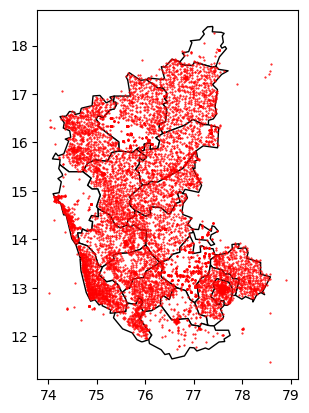

In [149]:
#For one cluster, the centroid will always just be the centroid of all coordinates, thus one run is enough
op=k_means(1)
cent1,var1=op[0],op[1]
#print(cent1,var1,sep='\n')
variations.append(var1)
sil_score.append(0)
#print(op[3])
Long=[]
Latt=[]
for el in op[3][0]:
    Long.append(el[1])
    Latt.append(el[0])
#print(riyal)
import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long,Latt,'ro',markersize=0.5)
plt.show()

In [92]:
#Using numpy makes array operations easier
cents2=np.array([[0.0,0.0],[0.0,0.0]])
var2=0
sil=0
for run in range(10):
    op=k_means(2)
    cents2+=(sorted(op[0]))
    var2+=op[1]
    sil+=op[2]
#cents2=np.array(cents2)
print(cents2/10,var2/10,sep='\n')
variations.append(var2/10)
sil_score.append(sil/10)


IndexError: list index out of range

In [429]:
cents3=np.array([[0.0,0.0],[0.0,0.0],[0.0,0.0]])
var3=0
a,b=0,0
for run in range(10):
    op=k_means(3)
    cents3+=(sorted(op[0]))
    #print(sorted(op[0]))
    var3+=op[1]
    a+=op[2]
    b+=op[3]
#cents2=np.array(cents2)
print(cents3/10,var3/10,sep='\n')
variations.append(var3/10)
sil_score.append((b-a)/max(a,b))

[[13.16001437 77.327861  ]
 [13.61030006 75.43857153]
 [16.16036731 75.95091044]]
7456.788412356384


In [436]:
cents4=np.array([[0.0,0.0],[0.0,0.0],[0.,0.],[0.,0.]])
var4=0
a,b=0,0
for run in range(10):
    op=k_means(4)
    cents4+=(sorted(op[0]))
    var4+=op[1]
    a+=op[2]
    b+=op[3]
#cents2=np.array(cents2)
print(cents4/10,var4/10,sep='\n')
variations.append(var4/10)
sil_score.append((b-a)/max(a,b))

[[13.17001502 77.35253577]
 [13.40526475 75.50714511]
 [15.57694819 75.25696195]
 [16.53726273 76.65633642]]
6385.285059432092


In [437]:
cents5=np.array([[0.0,0.0],[0.0,0.0],[0.,0.],[0.,0.],[0.,0.]])
var5=0
a,b=0,0
for run in range(10):
    op=k_means(5)
    cents5+=(sorted(op[0]))
    var5+=op[1]
    a+=op[2]
    b+=op[3]
#cents2=np.array(cents2)
print(cents5/10,var5/10,sep='\n')
variations.append(var5/10)
sil_score.append((b-a)/max(a,b))

[[13.11314077 76.21635429]
 [13.16833819 76.58718748]
 [14.69878544 75.89752439]
 [15.96157382 75.02713595]
 [16.70654107 76.67231466]]
5562.612542037527


In [438]:
cents6=np.array([[0.0,0.0],[0.0,0.0],[0.,0.],[0.,0.],[0.,0.],[0.,0.]])
var6=0
a,b=0,0
for run in range(10):
    op=k_means(6)
    cents6+=(sorted(op[0]))
    var6+=op[1]
    a+=op[2]
    b+=op[3]
#cents2=np.array(cents2)
print(cents6/10,var6/10,sep='\n')
variations.append(var6/10)
sil_score.append((b-a)/max(a,b))

[[12.9502437  75.8285922 ]
 [13.1608415  77.4621729 ]
 [13.9183528  75.02634681]
 [14.91800609 76.2047075 ]
 [16.04437268 75.08057216]
 [16.80274718 76.70576446]]
5100.963202175447


In [439]:
cents7=np.array([[0.0,0.0],[0.0,0.0],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.]])
var7=0
a,b=0,0
for run in range(10):
    op=k_means(7)
    cents7+=(sorted(op[0]))
    var7+=op[1]
    a+=op[2]
    b+=op[3]
#cents2=np.array(cents2)
print(cents7/10,var7/10,sep='\n')
variations.append(var7/10)
sil_score.append((b-a)/max(a,b))

[[12.96145811 75.65145916]
 [13.11378447 76.72692851]
 [13.73602807 76.49987134]
 [14.51390837 75.22239689]
 [15.4178567  76.23231138]
 [16.13274226 75.14333766]
 [16.91717756 76.76137006]]
4727.396935897194


In [440]:
cents8=np.array([[0.0,0.0],[0.0,0.0],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.]])
var8=0
a,b=0,0
for run in range(10):
    op=k_means(8)
    cents8+=(sorted(op[0]))
    var8+=op[1]
    a+=op[2]
    b+=op[3]
#cents2=np.array(cents2)
print(cents8/10,var8/10,sep='\n')
variations.append(var8/10)
sil_score.append((b-a)/max(a,b))

[[12.84506807 76.07379425]
 [13.1622312  77.02581265]
 [13.29037302 75.64961774]
 [14.28057632 75.77359563]
 [14.98139406 75.72422547]
 [15.6808262  75.62197558]
 [16.30228963 75.38907898]
 [16.96853738 76.85126194]]
4377.9735134264465


In [441]:
cents9=np.array([[0.0,0.0],[0.0,0.0],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.]])
var9=0
a,b=0,0
for run in range(10):
    op=k_means(9)
    cents9+=(sorted(op[0]))
    var9+=op[1]
    a+=op[2]
    b+=op[3]
#cents2=np.array(cents2)
print(cents9/10,var9/10,sep='\n')
variations.append(var9/10)
sil_score.append((b-a)/max(a,b))

[[12.80358142 75.91997192]
 [13.10792293 76.88415836]
 [13.27242998 76.09378951]
 [13.98811943 75.94317299]
 [14.56994413 75.20069551]
 [15.27896238 76.13531516]
 [15.89703668 75.34258403]
 [16.39012908 75.58410934]
 [17.00772778 76.89380366]]
4167.314236027412


In [442]:
cents10=np.array([[0.,0.],[0.0,0.0],[0.0,0.0],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.]])
var10=0
a,b=0,0
for run in range(10):
    op=k_means(10)
    cents10+=(sorted(op[0]))
    var10+=op[1]
    a+=op[2]
    b+=op[3]
#cents2=np.array(cents2)
print(cents10/10,var10/10,sep='\n')
variations.append(var10/10)
sil_score.append((b-a)/max(a,b))

[[12.7253228  76.2663032 ]
 [12.99437826 76.67085938]
 [13.18522147 76.09727769]
 [13.54493782 76.52237135]
 [14.1187879  75.86449754]
 [14.70624444 75.37515346]
 [15.35345596 75.93386909]
 [15.92392378 75.31844144]
 [16.41948957 75.58819132]
 [17.01252364 76.90086049]]
3948.7541108359474


In [458]:
cents11=np.array([[0.,0.],[0.,0.],[0.0,0.0],[0.0,0.0],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.]])
var11=0
a,b=0,0
for run in range(10):
    op=k_means(11)
    cents11+=(sorted(op[0]))
    var11+=op[1]
    a+=op[2]
    b+=op[3]
#cents2=np.array(cents2)
print(cents11/10,var11/10,sep='\n')
variations.append(var11/10)
sil_score.append((b-a)/max(a,b))

[[12.6438798  76.26145423]
 [12.96394494 76.36589765]
 [13.18299626 76.61372203]
 [13.49755329 76.16655792]
 [13.86648123 75.92455864]
 [14.4033536  75.69920712]
 [14.94178594 75.79868369]
 [15.42932441 75.47720747]
 [15.99547388 75.87566157]
 [16.40818147 75.66193196]
 [17.08014803 76.87808749]]
3816.7653201238427


In [459]:
cents12=np.array([[0.,0.],[0.,0.],[0.,0.],[0.0,0.0],[0.0,0.0],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.]])
var12=0
a,b=0,0
for run in range(10):
    op=k_means(12)
    cents12+=(sorted(op[0]))
    var12+=op[1]
    a+=op[2]
    b+=op[3]
#cents2=np.array(cents2)
print(cents12/10,var12/10,sep='\n')
variations.append(var12/10)
sil_score.append((b-a)/max(a,b))

[[12.69423716 76.03637419]
 [12.95727749 76.63376501]
 [13.1480898  76.09858791]
 [13.39639712 76.97649626]
 [13.93626754 75.87039148]
 [14.3031521  75.43536419]
 [14.81060953 75.48579591]
 [15.29243072 76.00608889]
 [15.80969202 75.50626875]
 [16.12869899 75.85630406]
 [16.51204869 75.75752484]
 [17.16937554 76.88934953]]
3616.7286838274026


In [461]:
cents13=np.array([[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.0,0.0],[0.0,0.0],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.]])
var13=0
a,b=0,0
for run in range(10):
    op=k_means(13)
    cents13+=(sorted(op[0]))
    var13+=op[1]
    a+=op[2]
    b+=op[3]
#cents2=np.array(cents2)
print(cents13/10,var13/10,sep='\n')
variations.append(var13/10)
sil_score.append((b-a)/max(a,b))

[[12.57527111 76.32157793]
 [12.88290808 76.35596344]
 [13.11360984 76.64322052]
 [13.24712958 76.39848038]
 [13.52751751 76.40704222]
 [14.00753507 75.70672072]
 [14.4579266  75.66720954]
 [14.91338656 75.01913286]
 [15.40188254 76.01866861]
 [15.79676551 75.7375859 ]
 [16.27631959 75.53799382]
 [16.54413301 76.06854712]
 [17.19235773 76.91342103]]
3483.126813639223


In [462]:
cents14=np.array([[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.0,0.0],[0.0,0.0],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.]])
var14=0
a,b=0,0
for run in range(10):
    op=k_means(14)
    cents14+=(sorted(op[0]))
    var14+=op[1]
    a+=op[2]
    b+=op[3]
#cents2=np.array(cents2)
print(cents14/10,var14/10,sep='\n')
variations.append(var14/10)
sil_score.append((b-a)/max(a,b))

[[12.50306301 76.4879875 ]
 [12.77939697 76.63906049]
 [13.07555965 75.91636529]
 [13.18878818 76.44155282]
 [13.38056578 76.92489482]
 [13.65342744 76.44152759]
 [14.05110369 76.03625063]
 [14.50165678 75.52361601]
 [14.80100659 75.24584188]
 [15.50369878 75.9491209 ]
 [15.76849497 75.83175697]
 [16.20770321 75.32785193]
 [16.64538893 75.93104776]
 [17.10961362 76.98918617]]
3348.8548643277913


In [464]:
cents15=np.array([[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.0,0.0],[0.0,0.0],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.]])
var15=0
a,b=0,0
for run in range(10):
    op=k_means(15)
    cents15+=(sorted(op[0]))
    var15+=op[1]
    a+=op[2]
    b+=op[3]
#cents2=np.array(cents2)
print(cents15/10,var15/10,sep='\n')
variations.append(var15/10)
sil_score.append((b-a)/max(a,b))

[[12.4643151  76.35958448]
 [12.71138975 76.44826271]
 [13.07608492 76.06301163]
 [13.20305501 76.4502664 ]
 [13.30004613 77.07702334]
 [13.576917   76.26487603]
 [14.02552941 76.32580393]
 [14.36438498 75.31438594]
 [14.72888633 75.0153925 ]
 [15.22495339 76.00023698]
 [15.62233264 75.93073467]
 [16.05815858 75.26857401]
 [16.29756175 76.26307424]
 [16.64056567 75.91739304]
 [17.23635644 76.95628946]]
3198.8484996031325


In [468]:
sil_score

[0,
 0.3653007784233487,
 0.3688744202023195,
 0.3674668247121996,
 0.1097803123831301,
 0.2588043093254701,
 0.2519843110733015,
 0.24736971597006413,
 0.24092712601894942,
 0.29726869317511506,
 0.2261234476270241,
 0.23172981888257477,
 0.2874431610866682,
 0.28611160356047366,
 0.26134301078353855]

In [478]:
for num in range(1,50):
    op=k_means(num)
    a,b=op[2],op[3]
    print(num," - ",(b-a)/max(a,b))

1  -  -1.0
2  -  0.3644174025815289
3  -  0.2623084221982743
4  -  0.347885807233403
5  -  -0.005308919989561326
6  -  0.23836501960777187
7  -  0.25307426686432744
8  -  0.10898068354850503
9  -  0.3477406960945197
10  -  0.32558872035249575
11  -  0.3200156338989272
12  -  0.33665911884879157
13  -  0.3845219685584894
14  -  0.5639037926381889
15  -  0.24854832997321494
16  -  0.44189605953607886
17  -  0.23506363577689093
18  -  0.2660171744479181
19  -  0.46700022736099117
20  -  0.4419069005464089
21  -  0.28693718018086267
22  -  0.4972397295987103
23  -  0.5369263383218414
24  -  0.5332261556607671
25  -  0.4071655056407551
26  -  0.3777323141390924
27  -  -0.14870398808723953
28  -  -0.05262666818894
29  -  0.5063639866523533
30  -  0.594550196850486
31  -  0.21128777908001045
32  -  0.5397117668070234
33  -  -0.1849215209691213
34  -  0.4518945278124129
35  -  0.14214236892166318
36  -  0.02136797420343941
37  -  0.13944404515271158
38  -  0.20289404957755236
39  -  0.43299767

In [247]:
i=2
sils_plot={}
while True:
    op=k_means(i)[2]
    print(i,"=",op)
    sils_plot[i]=op
    if(op>0.9):
        break
    else:
        i+=1

2 = 0.4398608012467731
3 = 0.4174934621871973
4 = 0.36363147408702534
5 = 0.38365131132401176
6 = 0.37868338451311706
7 = 0.36445432441558073
8 = 0.3664338419343079
9 = 0.33345644761707494
10 = 0.3582646635828469
11 = 0.30866802214642686
12 = 0.33152260677096484
13 = 0.3203757281792163
14 = 0.3327065490233815
15 = 0.30924977690619576
16 = 0.3246773035956095
17 = 0.32260937969453096
18 = 0.32661215508028935
19 = 0.32770771347568795
20 = 0.3289056002250344
21 = 0.32163520139913393
22 = 0.3375973800997024
23 = 0.3252181096337173
24 = 0.3211195029372379
25 = 0.3280001439844246
26 = 0.32912700644653414
27 = 0.326913042880428
28 = 0.3275025926408984
29 = 0.3280605104364826
30 = 0.32026018948817014
31 = 0.3343964943449439
32 = 0.3322512776145695
33 = 0.3306785437366228
34 = 0.32770948033133246
35 = 0.3188225892617631
36 = 0.3282086030144676
37 = 0.31895991083444697
38 = 0.33467375270959643
39 = 0.33010004160549344
40 = 0.32509895742061945
41 = 0.33334096213918973
42 = 0.32878459985434816
43 =

ZeroDivisionError: division by zero

In [249]:
i=87
while True:
    op=k_means(i)[2]
    print(i,"=",op)
    sils_plot[i]=op
    if(op>0.9):
        break
    else:
        i+=1

87 = 0.3291116781714255
88 = 0.32162006626180184
89 = 0.33469039617362834
90 = 0.32479782325476086
91 = 0.31727259528794194
92 = 0.3155059092981412


ZeroDivisionError: division by zero

In [251]:
i=93
while True:
    op=k_means(i)[2]
    print(i,"=",op)
    sils_plot[i]=op
    if(op>0.9):
        break
    else:
        i+=1

93 = 0.32551838842203856
94 = 0.33474702594110506
95 = 0.34218753075166813
96 = 0.3151311117677815
97 = 0.3322280943687281
98 = 0.3334949010183016
99 = 0.31674577502284135
100 = 0.31549700498728656
101 = 0.3310710457766302
102 = 0.33304156794653555
103 = 0.32339051366756855
104 = 0.3224066106859946
105 = 0.3357288990577531
106 = 0.32487441164399194
107 = 0.31591521713156356
108 = 0.32727986387388136
109 = 0.32856134000923126
110 = 0.32188552590310626
111 = 0.32293690681161896
112 = 0.33578688532980133
113 = 0.3280272525630212
114 = 0.3254775302886777
115 = 0.32772405207476085
116 = 0.32418126951472276
117 = 0.32380210270486337
118 = 0.33195716419699095
119 = 0.32411085468481876
120 = 0.3248223239391386
121 = 0.33063892328583966
122 = 0.34076146698093196
123 = 0.32242340470847214


ZeroDivisionError: division by zero

In [255]:
i=124
while True:
    op=k_means(i)[2]
    print(i,"=",op)
    sils_plot[i]=op
    if(op>0.9):
        break
    else:
        i+=1

124 = 0.32977769921057876
125 = 0.324176609752524
126 = 0.3281278521485164
127 = 0.32397376700701125
128 = 0.32972717012331043
129 = 0.32876935437448
130 = 0.3207572078497118
131 = 0.3276196467317776


ZeroDivisionError: division by zero

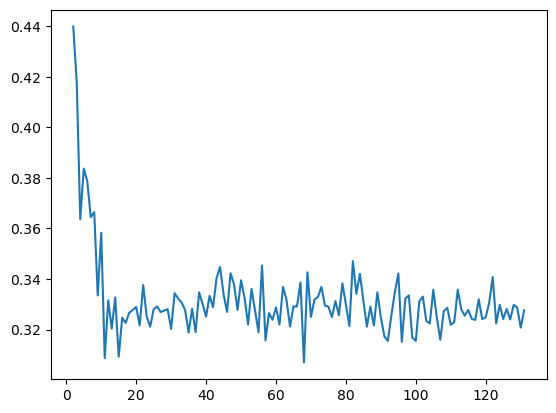

In [258]:
plt.plot(sils_plot.keys(),sils_plot.values())
plt.show()

In [64]:
'''elbow=[]
sils=[]
for j in range(2,150):
    print(j)
    op=k_means(j)
    sils.append(op[2])
    #tp=(b-a)/max(a,b)
    elbow.append(op[1])'''
plt.plot([k for k in range(2,150)],sils,'r*--')
plt.show()
plt.plot([k for k in range(2,150)],elbow,'bs--',markersize=0.25)
plt.show()
sils

NameError: name 'sils' is not defined

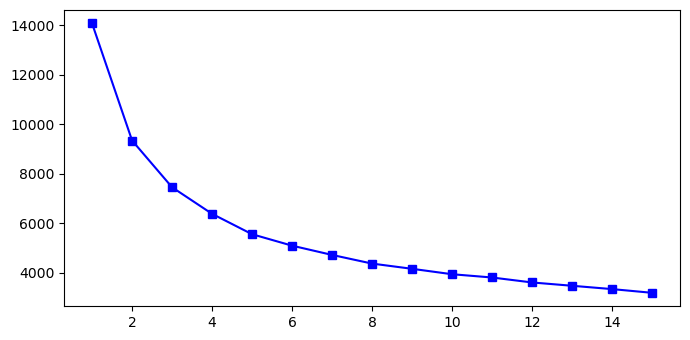

In [472]:
import matplotlib.pyplot as plt
plt.plot([k for k in range(1,16)],variations,'bs-')
plt.show()

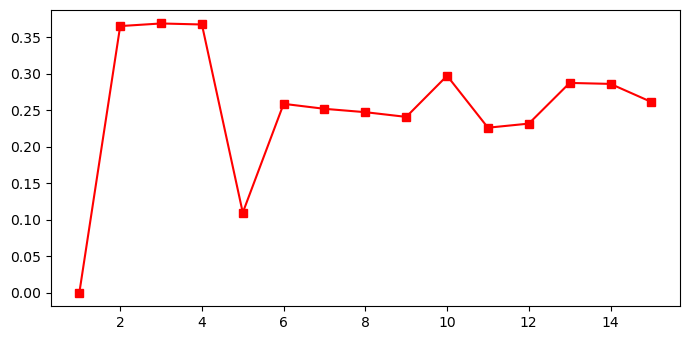

In [474]:
plt.plot([k for k in range(1,16)],sil_score,'rs-')
plt.show()

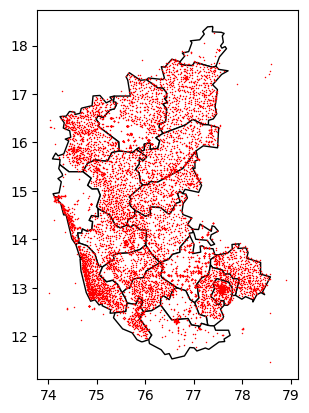

In [139]:
#Plotting the coordinates on a map
import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.show()


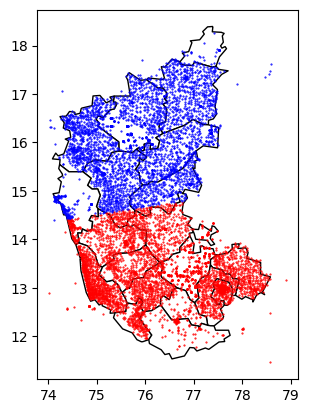

In [191]:
op=k_means(2)
#print(op[3][0])
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(2):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.5)
plt.plot(Long2,Latt2,'bo',markersize=0.5)
plt.show()

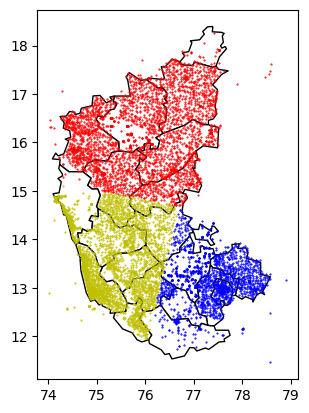

In [190]:
op=k_means(3)
#print(op[3][0])
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(3):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    else:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.5)
plt.plot(Long2,Latt2,'bo',markersize=0.5)
plt.plot(Long3,Latt3,'yo',markersize=0.5)
plt.show()

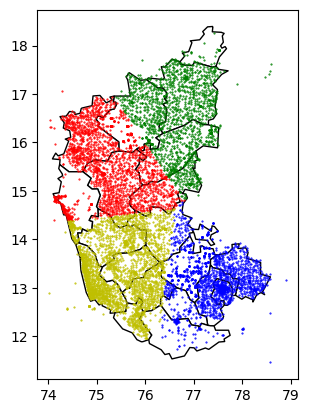

In [200]:
op=k_means(4)
#print(op[3][0])
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(4):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.5)
plt.plot(Long2,Latt2,'bo',markersize=0.5)
plt.plot(Long3,Latt3,'yo',markersize=0.5)
plt.plot(Long4,Latt4,'go',markersize=0.5)
plt.show()

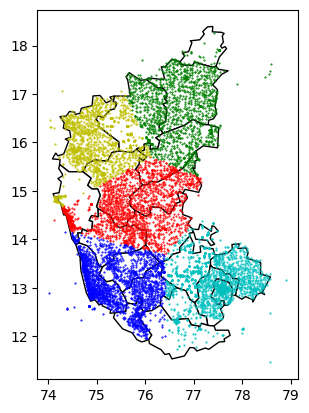

In [202]:
op=k_means(5)
#print(op[3][0])
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(5):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.5)
plt.plot(Long2,Latt2,'bo',markersize=0.5)
plt.plot(Long3,Latt3,'yo',markersize=0.5)
plt.plot(Long4,Latt4,'go',markersize=0.5)
plt.plot(Long5,Latt5,'co',markersize=0.5)
plt.show()

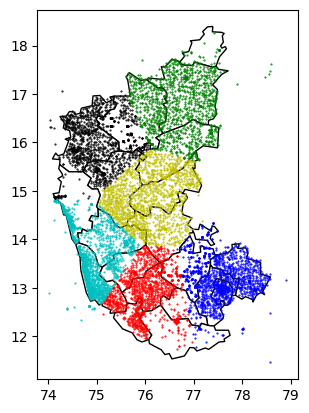

In [204]:
op=k_means(6)
#print(op[3][0])
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
Long6=[]
Latt6=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(6):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])
    elif a==5:
        for el in op[3][a]:
            Long6.append(el[1])
            Latt6.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.5)
plt.plot(Long2,Latt2,'bo',markersize=0.5)
plt.plot(Long3,Latt3,'yo',markersize=0.5)
plt.plot(Long4,Latt4,'go',markersize=0.5)
plt.plot(Long5,Latt5,'co',markersize=0.5)
plt.plot(Long6,Latt6,'ko',markersize=0.5)
plt.show()

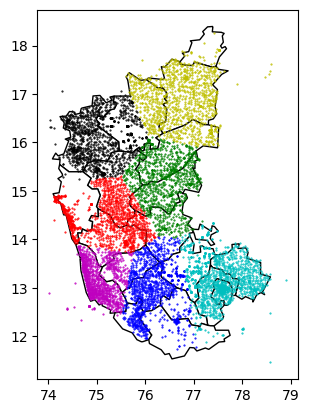

In [206]:
op=k_means(7)
#print(op[3][0])
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
Long6=[]
Latt6=[]
Long7=[]
Latt7=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(7):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])
    elif a==5:
        for el in op[3][a]:
            Long6.append(el[1])
            Latt6.append(el[0])
    elif a==6:
        for el in op[3][a]:
            Long7.append(el[1])
            Latt7.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.5)
plt.plot(Long2,Latt2,'bo',markersize=0.5)
plt.plot(Long3,Latt3,'yo',markersize=0.5)
plt.plot(Long4,Latt4,'go',markersize=0.5)
plt.plot(Long5,Latt5,'co',markersize=0.5)
plt.plot(Long6,Latt6,'ko',markersize=0.5)
plt.plot(Long7,Latt7,'mo',markersize=0.5)
plt.show()

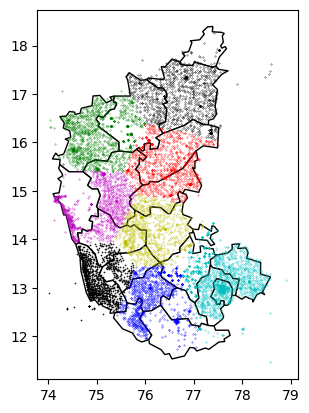

In [220]:
op=k_means(8)
#print(op[3][0])
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
Long6=[]
Latt6=[]
Long7=[]
Latt7=[]
Long8=[]
Latt8=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(8):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])
    elif a==5:
        for el in op[3][a]:
            Long6.append(el[1])
            Latt6.append(el[0])
    elif a==6:
        for el in op[3][a]:
            Long7.append(el[1])
            Latt7.append(el[0])
    elif a==7:
        for el in op[3][a]:
            Long8.append(el[1])
            Latt8.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.25)
plt.plot(Long2,Latt2,'bo',markersize=0.25)
plt.plot(Long3,Latt3,'yo',markersize=0.25)
plt.plot(Long4,Latt4,'go',markersize=0.25)
plt.plot(Long5,Latt5,'co',markersize=0.25)
plt.plot(Long6,Latt6,'ko',markersize=0.25)
plt.plot(Long7,Latt7,'mo',markersize=0.25)
plt.plot(Long8,Latt8,'ks',markersize=0.25)
plt.show()

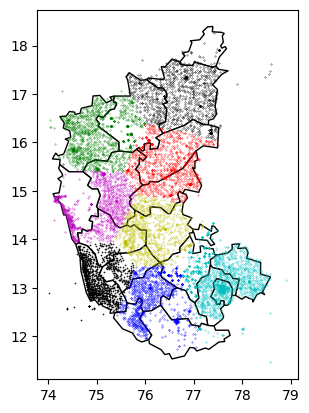

In [220]:
op=k_means(8)
#print(op[3][0])
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
Long6=[]
Latt6=[]
Long7=[]
Latt7=[]
Long8=[]
Latt8=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(8):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])
    elif a==5:
        for el in op[3][a]:
            Long6.append(el[1])
            Latt6.append(el[0])
    elif a==6:
        for el in op[3][a]:
            Long7.append(el[1])
            Latt7.append(el[0])
    elif a==7:
        for el in op[3][a]:
            Long8.append(el[1])
            Latt8.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.25)
plt.plot(Long2,Latt2,'bo',markersize=0.25)
plt.plot(Long3,Latt3,'yo',markersize=0.25)
plt.plot(Long4,Latt4,'go',markersize=0.25)
plt.plot(Long5,Latt5,'co',markersize=0.25)
plt.plot(Long6,Latt6,'ko',markersize=0.25)
plt.plot(Long7,Latt7,'mo',markersize=0.25)
plt.plot(Long8,Latt8,'ks',markersize=0.25)
plt.show()

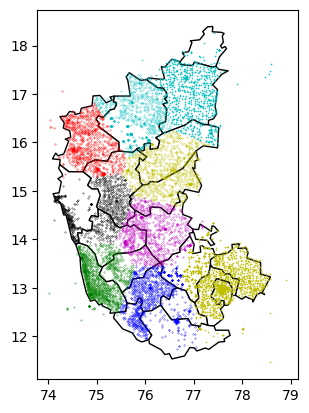

In [237]:
op=k_means(9)
#print(op[3][0])
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
Long6=[]
Latt6=[]
Long7=[]
Latt7=[]
Long8=[]
Latt8=[]
Long9=[]
Latt9=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(9):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])
    elif a==5:
        for el in op[3][a]:
            Long6.append(el[1])
            Latt6.append(el[0])
    elif a==6:
        for el in op[3][a]:
            Long7.append(el[1])
            Latt7.append(el[0])
    elif a==7:
        for el in op[3][a]:
            Long8.append(el[1])
            Latt8.append(el[0])
    elif a==8:
        for el in op[3][a]:
            Long9.append(el[1])
            Latt9.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.25)
plt.plot(Long2,Latt2,'bo',markersize=0.25)
plt.plot(Long3,Latt3,'yo',markersize=0.25)
plt.plot(Long4,Latt4,'go',markersize=0.25)
plt.plot(Long5,Latt5,'co',markersize=0.25)
plt.plot(Long6,Latt6,'ko',markersize=0.25)
plt.plot(Long7,Latt7,'mo',markersize=0.25)
plt.plot(Long8,Latt8,'cs',markersize=0.25)
plt.plot(Long9,Latt9,'ys',markersize=0.25)
plt.show()

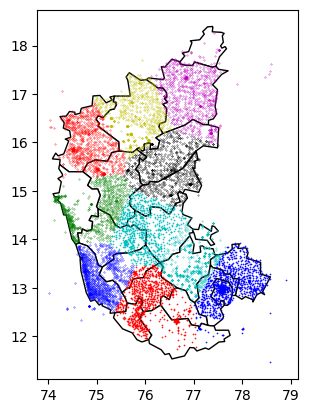

In [231]:
op=k_means(10)
#print(op[3][0])
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
Long6=[]
Latt6=[]
Long7=[]
Latt7=[]
Long8=[]
Latt8=[]
Long9=[]
Latt9=[]
Latt10=[]
Long10=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(10):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])
    elif a==5:
        for el in op[3][a]:
            Long6.append(el[1])
            Latt6.append(el[0])
    elif a==6:
        for el in op[3][a]:
            Long7.append(el[1])
            Latt7.append(el[0])
    elif a==7:
        for el in op[3][a]:
            Long8.append(el[1])
            Latt8.append(el[0])
    elif a==8:
        for el in op[3][a]:
            Long9.append(el[1])
            Latt9.append(el[0])
    elif a==9:
        for el in op[3][a]:
            Long10.append(el[1])
            Latt10.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.25)
plt.plot(Long2,Latt2,'bo',markersize=0.25)
plt.plot(Long3,Latt3,'yo',markersize=0.25)
plt.plot(Long4,Latt4,'go',markersize=0.25)
plt.plot(Long5,Latt5,'co',markersize=0.25)
plt.plot(Long6,Latt6,'ko',markersize=0.25)
plt.plot(Long7,Latt7,'mo',markersize=0.25)
plt.plot(Long8,Latt8,'cs',markersize=0.25)
plt.plot(Long9,Latt9,'rs',markersize=0.25)
plt.plot(Long10,Latt10,'bs',markersize=0.25)
plt.show()

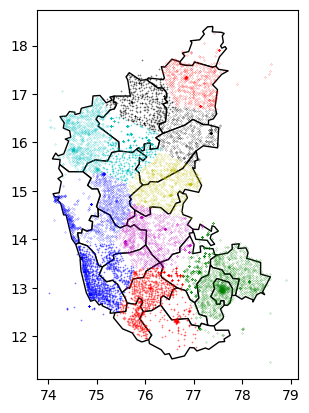

In [266]:
op=k_means(11)
#print(op[3][0])
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
Long6=[]
Latt6=[]
Long7=[]
Latt7=[]
Long8=[]
Latt8=[]
Long9=[]
Latt9=[]
Latt10=[]
Long10=[]
Latt11=[]
Long11=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(11):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])
    elif a==5:
        for el in op[3][a]:
            Long6.append(el[1])
            Latt6.append(el[0])
    elif a==6:
        for el in op[3][a]:
            Long7.append(el[1])
            Latt7.append(el[0])
    elif a==7:
        for el in op[3][a]:
            Long8.append(el[1])
            Latt8.append(el[0])
    elif a==8:
        for el in op[3][a]:
            Long9.append(el[1])
            Latt9.append(el[0])
    elif a==9:
        for el in op[3][a]:
            Long10.append(el[1])
            Latt10.append(el[0])
    elif a==10:
        for el in op[3][a]:
            Long11.append(el[1])
            Latt11.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.15)
plt.plot(Long2,Latt2,'bo',markersize=0.15)
plt.plot(Long3,Latt3,'yo',markersize=0.15)
plt.plot(Long4,Latt4,'go',markersize=0.15)
plt.plot(Long5,Latt5,'co',markersize=0.15)
plt.plot(Long6,Latt6,'ko',markersize=0.15)
plt.plot(Long7,Latt7,'mo',markersize=0.15)
plt.plot(Long8,Latt8,'cs',markersize=0.15)
plt.plot(Long9,Latt9,'rs',markersize=0.15)
plt.plot(Long10,Latt10,'bs',markersize=0.15)
plt.plot(Long11,Latt11,'ks',markersize=0.15)
plt.show()

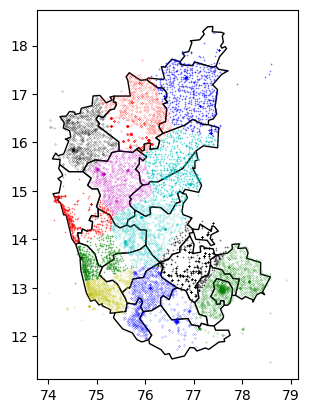

In [268]:
op=k_means(12)
#print(op[3][0])
Long12=[]
Latt12=[]
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
Long6=[]
Latt6=[]
Long7=[]
Latt7=[]
Long8=[]
Latt8=[]
Long9=[]
Latt9=[]
Latt10=[]
Long10=[]
Latt11=[]
Long11=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(12):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])
    elif a==5:
        for el in op[3][a]:
            Long6.append(el[1])
            Latt6.append(el[0])
    elif a==6:
        for el in op[3][a]:
            Long7.append(el[1])
            Latt7.append(el[0])
    elif a==7:
        for el in op[3][a]:
            Long8.append(el[1])
            Latt8.append(el[0])
    elif a==8:
        for el in op[3][a]:
            Long9.append(el[1])
            Latt9.append(el[0])
    elif a==9:
        for el in op[3][a]:
            Long10.append(el[1])
            Latt10.append(el[0])
    elif a==10:
        for el in op[3][a]:
            Long11.append(el[1])
            Latt11.append(el[0])
    elif a==11:
        for el in op[3][a]:
            Long12.append(el[1])
            Latt12.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.15)
plt.plot(Long2,Latt2,'bo',markersize=0.15)
plt.plot(Long3,Latt3,'yo',markersize=0.15)
plt.plot(Long4,Latt4,'go',markersize=0.15)
plt.plot(Long5,Latt5,'co',markersize=0.15)
plt.plot(Long6,Latt6,'ko',markersize=0.15)
plt.plot(Long7,Latt7,'mo',markersize=0.15)
plt.plot(Long8,Latt8,'cs',markersize=0.15)
plt.plot(Long9,Latt9,'rs',markersize=0.15)
plt.plot(Long10,Latt10,'bs',markersize=0.15)
plt.plot(Long11,Latt11,'ks',markersize=0.15)
plt.plot(Long12,Latt12,'gs',markersize=0.15)
plt.show()

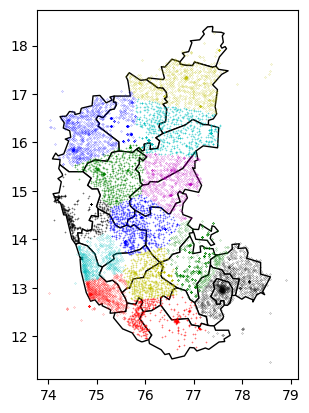

In [270]:
op=k_means(13)
#print(op[3][0])
Long12=[]
Latt12=[]
Long13=[]
Latt13=[]
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
Long6=[]
Latt6=[]
Long7=[]
Latt7=[]
Long8=[]
Latt8=[]
Long9=[]
Latt9=[]
Latt10=[]
Long10=[]
Latt11=[]
Long11=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(13):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])
    elif a==5:
        for el in op[3][a]:
            Long6.append(el[1])
            Latt6.append(el[0])
    elif a==6:
        for el in op[3][a]:
            Long7.append(el[1])
            Latt7.append(el[0])
    elif a==7:
        for el in op[3][a]:
            Long8.append(el[1])
            Latt8.append(el[0])
    elif a==8:
        for el in op[3][a]:
            Long9.append(el[1])
            Latt9.append(el[0])
    elif a==9:
        for el in op[3][a]:
            Long10.append(el[1])
            Latt10.append(el[0])
    elif a==10:
        for el in op[3][a]:
            Long11.append(el[1])
            Latt11.append(el[0])
    elif a==11:
        for el in op[3][a]:
            Long12.append(el[1])
            Latt12.append(el[0])
    elif a==12:
        for el in op[3][a]:
            Long13.append(el[1])
            Latt13.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.15)
plt.plot(Long2,Latt2,'bo',markersize=0.15)
plt.plot(Long3,Latt3,'yo',markersize=0.15)
plt.plot(Long4,Latt4,'go',markersize=0.15)
plt.plot(Long5,Latt5,'co',markersize=0.15)
plt.plot(Long6,Latt6,'ko',markersize=0.15)
plt.plot(Long7,Latt7,'mo',markersize=0.15)
plt.plot(Long8,Latt8,'cs',markersize=0.15)
plt.plot(Long9,Latt9,'rs',markersize=0.15)
plt.plot(Long10,Latt10,'bs',markersize=0.15)
plt.plot(Long11,Latt11,'ks',markersize=0.15)
plt.plot(Long12,Latt12,'gs',markersize=0.15)
plt.plot(Long13,Latt13,'ys',markersize=0.15)
plt.show()

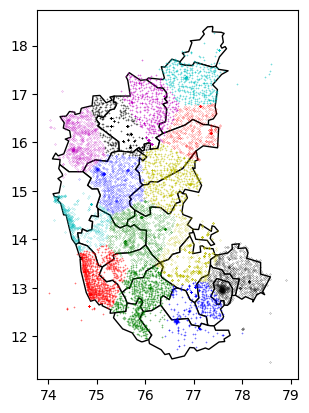

In [272]:
op=k_means(14)
#print(op[3][0])
Long14=[]
Latt14=[]
Long12=[]
Latt12=[]
Long13=[]
Latt13=[]
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
Long6=[]
Latt6=[]
Long7=[]
Latt7=[]
Long8=[]
Latt8=[]
Long9=[]
Latt9=[]
Latt10=[]
Long10=[]
Latt11=[]
Long11=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(14):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])
    elif a==5:
        for el in op[3][a]:
            Long6.append(el[1])
            Latt6.append(el[0])
    elif a==6:
        for el in op[3][a]:
            Long7.append(el[1])
            Latt7.append(el[0])
    elif a==7:
        for el in op[3][a]:
            Long8.append(el[1])
            Latt8.append(el[0])
    elif a==8:
        for el in op[3][a]:
            Long9.append(el[1])
            Latt9.append(el[0])
    elif a==9:
        for el in op[3][a]:
            Long10.append(el[1])
            Latt10.append(el[0])
    elif a==10:
        for el in op[3][a]:
            Long11.append(el[1])
            Latt11.append(el[0])
    elif a==11:
        for el in op[3][a]:
            Long12.append(el[1])
            Latt12.append(el[0])
    elif a==12:
        for el in op[3][a]:
            Long13.append(el[1])
            Latt13.append(el[0])
    elif a==13:
        for el in op[3][a]:
            Long14.append(el[1])
            Latt14.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.15)
plt.plot(Long2,Latt2,'bo',markersize=0.15)
plt.plot(Long3,Latt3,'yo',markersize=0.15)
plt.plot(Long4,Latt4,'go',markersize=0.15)
plt.plot(Long5,Latt5,'co',markersize=0.15)
plt.plot(Long6,Latt6,'ko',markersize=0.15)
plt.plot(Long7,Latt7,'mo',markersize=0.15)
plt.plot(Long8,Latt8,'cs',markersize=0.15)
plt.plot(Long9,Latt9,'rs',markersize=0.15)
plt.plot(Long10,Latt10,'bs',markersize=0.15)
plt.plot(Long11,Latt11,'ks',markersize=0.15)
plt.plot(Long12,Latt12,'gs',markersize=0.15)
plt.plot(Long13,Latt13,'ys',markersize=0.15)
plt.plot(Long14,Latt14,'ms',markersize=0.15)
plt.show()

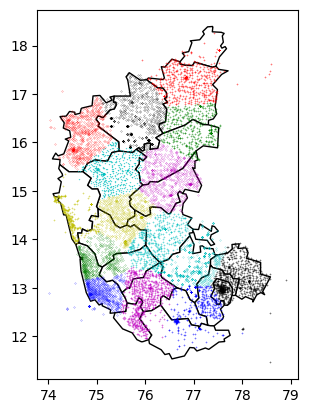

In [278]:
op=k_means(15)
#print(op[3][0])
Long15=[]
Latt15=[]
Long14=[]
Latt14=[]
Long12=[]
Latt12=[]
Long13=[]
Latt13=[]
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
Long6=[]
Latt6=[]
Long7=[]
Latt7=[]
Long8=[]
Latt8=[]
Long9=[]
Latt9=[]
Latt10=[]
Long10=[]
Latt11=[]
Long11=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(15):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])
    elif a==5:
        for el in op[3][a]:
            Long6.append(el[1])
            Latt6.append(el[0])
    elif a==6:
        for el in op[3][a]:
            Long7.append(el[1])
            Latt7.append(el[0])
    elif a==7:
        for el in op[3][a]:
            Long8.append(el[1])
            Latt8.append(el[0])
    elif a==8:
        for el in op[3][a]:
            Long9.append(el[1])
            Latt9.append(el[0])
    elif a==9:
        for el in op[3][a]:
            Long10.append(el[1])
            Latt10.append(el[0])
    elif a==10:
        for el in op[3][a]:
            Long11.append(el[1])
            Latt11.append(el[0])
    elif a==11:
        for el in op[3][a]:
            Long12.append(el[1])
            Latt12.append(el[0])
    elif a==12:
        for el in op[3][a]:
            Long13.append(el[1])
            Latt13.append(el[0])
    elif a==13:
        for el in op[3][a]:
            Long14.append(el[1])
            Latt14.append(el[0])
    elif a==14:
        for el in op[3][a]:
            Long15.append(el[1])
            Latt15.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.15)
plt.plot(Long2,Latt2,'bo',markersize=0.15)
plt.plot(Long3,Latt3,'yo',markersize=0.15)
plt.plot(Long4,Latt4,'go',markersize=0.15)
plt.plot(Long5,Latt5,'co',markersize=0.15)
plt.plot(Long6,Latt6,'ko',markersize=0.15)
plt.plot(Long7,Latt7,'mo',markersize=0.15)
plt.plot(Long8,Latt8,'cs',markersize=0.15)
plt.plot(Long9,Latt9,'rs',markersize=0.15)
plt.plot(Long10,Latt10,'bs',markersize=0.15)
plt.plot(Long11,Latt11,'ks',markersize=0.15)
plt.plot(Long12,Latt12,'gs',markersize=0.15)
plt.plot(Long13,Latt13,'ys',markersize=0.15)
plt.plot(Long14,Latt14,'ms',markersize=0.15)
plt.plot(Long15,Latt15,'c^',markersize=0.15)
plt.show()

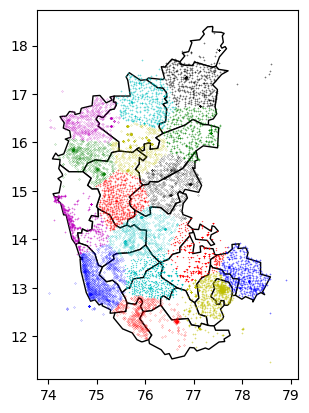

In [280]:
op=k_means(16)
#print(op[3][0])
Long16=[]
Latt16=[]
Long15=[]
Latt15=[]
Long14=[]
Latt14=[]
Long12=[]
Latt12=[]
Long13=[]
Latt13=[]
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
Long6=[]
Latt6=[]
Long7=[]
Latt7=[]
Long8=[]
Latt8=[]
Long9=[]
Latt9=[]
Latt10=[]
Long10=[]
Latt11=[]
Long11=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(16):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])
    elif a==5:
        for el in op[3][a]:
            Long6.append(el[1])
            Latt6.append(el[0])
    elif a==6:
        for el in op[3][a]:
            Long7.append(el[1])
            Latt7.append(el[0])
    elif a==7:
        for el in op[3][a]:
            Long8.append(el[1])
            Latt8.append(el[0])
    elif a==8:
        for el in op[3][a]:
            Long9.append(el[1])
            Latt9.append(el[0])
    elif a==9:
        for el in op[3][a]:
            Long10.append(el[1])
            Latt10.append(el[0])
    elif a==10:
        for el in op[3][a]:
            Long11.append(el[1])
            Latt11.append(el[0])
    elif a==11:
        for el in op[3][a]:
            Long12.append(el[1])
            Latt12.append(el[0])
    elif a==12:
        for el in op[3][a]:
            Long13.append(el[1])
            Latt13.append(el[0])
    elif a==13:
        for el in op[3][a]:
            Long14.append(el[1])
            Latt14.append(el[0])
    elif a==14:
        for el in op[3][a]:
            Long15.append(el[1])
            Latt15.append(el[0])
    elif a==15:
        for el in op[3][a]:
            Long16.append(el[1])
            Latt16.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.15)
plt.plot(Long2,Latt2,'bo',markersize=0.15)
plt.plot(Long3,Latt3,'yo',markersize=0.15)
plt.plot(Long4,Latt4,'go',markersize=0.15)
plt.plot(Long5,Latt5,'co',markersize=0.15)
plt.plot(Long6,Latt6,'ko',markersize=0.15)
plt.plot(Long7,Latt7,'mo',markersize=0.15)
plt.plot(Long8,Latt8,'cs',markersize=0.15)
plt.plot(Long9,Latt9,'rs',markersize=0.15)
plt.plot(Long10,Latt10,'bs',markersize=0.15)
plt.plot(Long11,Latt11,'ks',markersize=0.15)
plt.plot(Long12,Latt12,'gs',markersize=0.15)
plt.plot(Long13,Latt13,'ys',markersize=0.15)
plt.plot(Long14,Latt14,'ms',markersize=0.15)
plt.plot(Long15,Latt15,'c^',markersize=0.15)
plt.plot(Long16,Latt16,'r^',markersize=0.15)
plt.show()

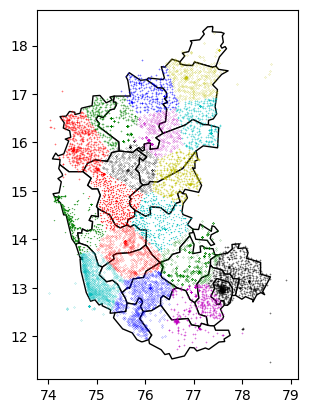

In [284]:
op=k_means(17)
#print(op[3][0])
Long17=[]
Latt17=[]
Long16=[]
Latt16=[]
Long15=[]
Latt15=[]
Long14=[]
Latt14=[]
Long12=[]
Latt12=[]
Long13=[]
Latt13=[]
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
Long6=[]
Latt6=[]
Long7=[]
Latt7=[]
Long8=[]
Latt8=[]
Long9=[]
Latt9=[]
Latt10=[]
Long10=[]
Latt11=[]
Long11=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(17):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])
    elif a==5:
        for el in op[3][a]:
            Long6.append(el[1])
            Latt6.append(el[0])
    elif a==6:
        for el in op[3][a]:
            Long7.append(el[1])
            Latt7.append(el[0])
    elif a==7:
        for el in op[3][a]:
            Long8.append(el[1])
            Latt8.append(el[0])
    elif a==8:
        for el in op[3][a]:
            Long9.append(el[1])
            Latt9.append(el[0])
    elif a==9:
        for el in op[3][a]:
            Long10.append(el[1])
            Latt10.append(el[0])
    elif a==10:
        for el in op[3][a]:
            Long11.append(el[1])
            Latt11.append(el[0])
    elif a==11:
        for el in op[3][a]:
            Long12.append(el[1])
            Latt12.append(el[0])
    elif a==12:
        for el in op[3][a]:
            Long13.append(el[1])
            Latt13.append(el[0])
    elif a==13:
        for el in op[3][a]:
            Long14.append(el[1])
            Latt14.append(el[0])
    elif a==14:
        for el in op[3][a]:
            Long15.append(el[1])
            Latt15.append(el[0])
    elif a==15:
        for el in op[3][a]:
            Long16.append(el[1])
            Latt16.append(el[0])
    elif a==16:
        for el in op[3][a]:
            Long17.append(el[1])
            Latt17.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.15)
plt.plot(Long2,Latt2,'bo',markersize=0.15)
plt.plot(Long3,Latt3,'yo',markersize=0.15)
plt.plot(Long4,Latt4,'go',markersize=0.15)
plt.plot(Long5,Latt5,'co',markersize=0.15)
plt.plot(Long6,Latt6,'ko',markersize=0.15)
plt.plot(Long7,Latt7,'mo',markersize=0.15)
plt.plot(Long8,Latt8,'cs',markersize=0.15)
plt.plot(Long9,Latt9,'rs',markersize=0.15)
plt.plot(Long10,Latt10,'bs',markersize=0.15)
plt.plot(Long11,Latt11,'ks',markersize=0.15)
plt.plot(Long12,Latt12,'gs',markersize=0.15)
plt.plot(Long13,Latt13,'ys',markersize=0.15)
plt.plot(Long14,Latt14,'ms',markersize=0.15)
plt.plot(Long15,Latt15,'c^',markersize=0.15)
plt.plot(Long16,Latt16,'r^',markersize=0.15)
plt.plot(Long17,Latt17,'g^',markersize=0.15)
plt.show()

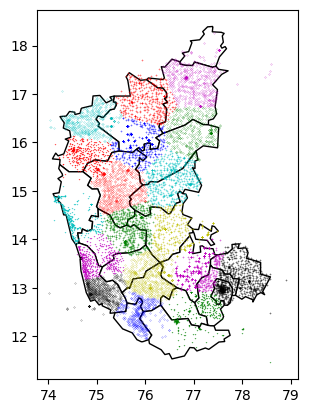

In [290]:
op=k_means(18)
#print(op[3][0])
Long18=[]
Latt18=[]
Long17=[]
Latt17=[]
Long16=[]
Latt16=[]
Long15=[]
Latt15=[]
Long14=[]
Latt14=[]
Long12=[]
Latt12=[]
Long13=[]
Latt13=[]
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
Long6=[]
Latt6=[]
Long7=[]
Latt7=[]
Long8=[]
Latt8=[]
Long9=[]
Latt9=[]
Latt10=[]
Long10=[]
Latt11=[]
Long11=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(18):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])
    elif a==5:
        for el in op[3][a]:
            Long6.append(el[1])
            Latt6.append(el[0])
    elif a==6:
        for el in op[3][a]:
            Long7.append(el[1])
            Latt7.append(el[0])
    elif a==7:
        for el in op[3][a]:
            Long8.append(el[1])
            Latt8.append(el[0])
    elif a==8:
        for el in op[3][a]:
            Long9.append(el[1])
            Latt9.append(el[0])
    elif a==9:
        for el in op[3][a]:
            Long10.append(el[1])
            Latt10.append(el[0])
    elif a==10:
        for el in op[3][a]:
            Long11.append(el[1])
            Latt11.append(el[0])
    elif a==11:
        for el in op[3][a]:
            Long12.append(el[1])
            Latt12.append(el[0])
    elif a==12:
        for el in op[3][a]:
            Long13.append(el[1])
            Latt13.append(el[0])
    elif a==13:
        for el in op[3][a]:
            Long14.append(el[1])
            Latt14.append(el[0])
    elif a==14:
        for el in op[3][a]:
            Long15.append(el[1])
            Latt15.append(el[0])
    elif a==15:
        for el in op[3][a]:
            Long16.append(el[1])
            Latt16.append(el[0])
    elif a==16:
        for el in op[3][a]:
            Long17.append(el[1])
            Latt17.append(el[0])
    elif a==17:
        for el in op[3][a]:
            Long18.append(el[1])
            Latt18.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.15)
plt.plot(Long2,Latt2,'bo',markersize=0.15)
plt.plot(Long3,Latt3,'yo',markersize=0.15)
plt.plot(Long4,Latt4,'go',markersize=0.15)
plt.plot(Long5,Latt5,'co',markersize=0.15)
plt.plot(Long6,Latt6,'ko',markersize=0.15)
plt.plot(Long7,Latt7,'mo',markersize=0.15)
plt.plot(Long8,Latt8,'cs',markersize=0.15)
plt.plot(Long9,Latt9,'rs',markersize=0.15)
plt.plot(Long10,Latt10,'bs',markersize=0.15)
plt.plot(Long11,Latt11,'ks',markersize=0.15)
plt.plot(Long12,Latt12,'gs',markersize=0.15)
plt.plot(Long13,Latt13,'ys',markersize=0.15)
plt.plot(Long14,Latt14,'ms',markersize=0.15)
plt.plot(Long15,Latt15,'c^',markersize=0.15)
plt.plot(Long16,Latt16,'r^',markersize=0.15)
plt.plot(Long17,Latt17,'g^',markersize=0.15)
plt.plot(Long18,Latt18,'m^',markersize=0.15)
plt.show()

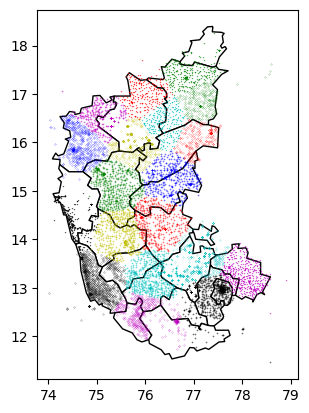

In [294]:
op=k_means(19)
#print(op[3][0])
Long19=[]
Latt19=[]
Long18=[]
Latt18=[]
Long17=[]
Latt17=[]
Long16=[]
Latt16=[]
Long15=[]
Latt15=[]
Long14=[]
Latt14=[]
Long12=[]
Latt12=[]
Long13=[]
Latt13=[]
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
Long6=[]
Latt6=[]
Long7=[]
Latt7=[]
Long8=[]
Latt8=[]
Long9=[]
Latt9=[]
Latt10=[]
Long10=[]
Latt11=[]
Long11=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(19):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])
    elif a==5:
        for el in op[3][a]:
            Long6.append(el[1])
            Latt6.append(el[0])
    elif a==6:
        for el in op[3][a]:
            Long7.append(el[1])
            Latt7.append(el[0])
    elif a==7:
        for el in op[3][a]:
            Long8.append(el[1])
            Latt8.append(el[0])
    elif a==8:
        for el in op[3][a]:
            Long9.append(el[1])
            Latt9.append(el[0])
    elif a==9:
        for el in op[3][a]:
            Long10.append(el[1])
            Latt10.append(el[0])
    elif a==10:
        for el in op[3][a]:
            Long11.append(el[1])
            Latt11.append(el[0])
    elif a==11:
        for el in op[3][a]:
            Long12.append(el[1])
            Latt12.append(el[0])
    elif a==12:
        for el in op[3][a]:
            Long13.append(el[1])
            Latt13.append(el[0])
    elif a==13:
        for el in op[3][a]:
            Long14.append(el[1])
            Latt14.append(el[0])
    elif a==14:
        for el in op[3][a]:
            Long15.append(el[1])
            Latt15.append(el[0])
    elif a==15:
        for el in op[3][a]:
            Long16.append(el[1])
            Latt16.append(el[0])
    elif a==16:
        for el in op[3][a]:
            Long17.append(el[1])
            Latt17.append(el[0])
    elif a==17:
        for el in op[3][a]:
            Long18.append(el[1])
            Latt18.append(el[0])
    elif a==18:
        for el in op[3][a]:
            Long19.append(el[1])
            Latt19.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.15)
plt.plot(Long2,Latt2,'bo',markersize=0.15)
plt.plot(Long3,Latt3,'yo',markersize=0.15)
plt.plot(Long4,Latt4,'go',markersize=0.15)
plt.plot(Long5,Latt5,'co',markersize=0.15)
plt.plot(Long6,Latt6,'ko',markersize=0.15)
plt.plot(Long7,Latt7,'mo',markersize=0.15)
plt.plot(Long8,Latt8,'cs',markersize=0.15)
plt.plot(Long9,Latt9,'rs',markersize=0.15)
plt.plot(Long10,Latt10,'bs',markersize=0.15)
plt.plot(Long11,Latt11,'ks',markersize=0.15)
plt.plot(Long12,Latt12,'gs',markersize=0.15)
plt.plot(Long13,Latt13,'ys',markersize=0.15)
plt.plot(Long14,Latt14,'ms',markersize=0.15)
plt.plot(Long15,Latt15,'c^',markersize=0.15)
plt.plot(Long16,Latt16,'r^',markersize=0.15)
plt.plot(Long17,Latt17,'g^',markersize=0.15)
plt.plot(Long18,Latt18,'m^',markersize=0.15)
plt.plot(Long19,Latt19,'k^',markersize=0.15)
plt.show()

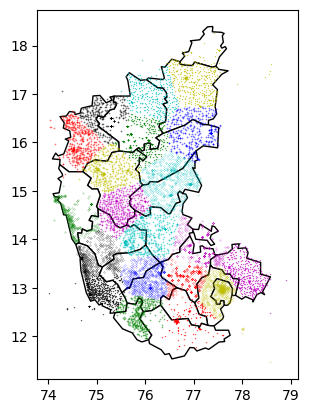

In [299]:
op=k_means(20)
#print(op[3][0])
Long20=[]
Latt20=[]
Long19=[]
Latt19=[]
Long18=[]
Latt18=[]
Long17=[]
Latt17=[]
Long16=[]
Latt16=[]
Long15=[]
Latt15=[]
Long14=[]
Latt14=[]
Long12=[]
Latt12=[]
Long13=[]
Latt13=[]
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
Long6=[]
Latt6=[]
Long7=[]
Latt7=[]
Long8=[]
Latt8=[]
Long9=[]
Latt9=[]
Latt10=[]
Long10=[]
Latt11=[]
Long11=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(20):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])
    elif a==5:
        for el in op[3][a]:
            Long6.append(el[1])
            Latt6.append(el[0])
    elif a==6:
        for el in op[3][a]:
            Long7.append(el[1])
            Latt7.append(el[0])
    elif a==7:
        for el in op[3][a]:
            Long8.append(el[1])
            Latt8.append(el[0])
    elif a==8:
        for el in op[3][a]:
            Long9.append(el[1])
            Latt9.append(el[0])
    elif a==9:
        for el in op[3][a]:
            Long10.append(el[1])
            Latt10.append(el[0])
    elif a==10:
        for el in op[3][a]:
            Long11.append(el[1])
            Latt11.append(el[0])
    elif a==11:
        for el in op[3][a]:
            Long12.append(el[1])
            Latt12.append(el[0])
    elif a==12:
        for el in op[3][a]:
            Long13.append(el[1])
            Latt13.append(el[0])
    elif a==13:
        for el in op[3][a]:
            Long14.append(el[1])
            Latt14.append(el[0])
    elif a==14:
        for el in op[3][a]:
            Long15.append(el[1])
            Latt15.append(el[0])
    elif a==15:
        for el in op[3][a]:
            Long16.append(el[1])
            Latt16.append(el[0])
    elif a==16:
        for el in op[3][a]:
            Long17.append(el[1])
            Latt17.append(el[0])
    elif a==17:
        for el in op[3][a]:
            Long18.append(el[1])
            Latt18.append(el[0])
    elif a==18:
        for el in op[3][a]:
            Long19.append(el[1])
            Latt19.append(el[0])
    elif a==19:
        for el in op[3][a]:
            Long20.append(el[1])
            Latt20.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.15)
plt.plot(Long2,Latt2,'bo',markersize=0.15)
plt.plot(Long3,Latt3,'yo',markersize=0.15)
plt.plot(Long4,Latt4,'go',markersize=0.15)
plt.plot(Long5,Latt5,'co',markersize=0.15)
plt.plot(Long6,Latt6,'ko',markersize=0.15)
plt.plot(Long7,Latt7,'mo',markersize=0.15)
plt.plot(Long8,Latt8,'cs',markersize=0.15)
plt.plot(Long9,Latt9,'rs',markersize=0.15)
plt.plot(Long10,Latt10,'bs',markersize=0.15)
plt.plot(Long11,Latt11,'ks',markersize=0.15)
plt.plot(Long12,Latt12,'gs',markersize=0.15)
plt.plot(Long13,Latt13,'ys',markersize=0.15)
plt.plot(Long14,Latt14,'ms',markersize=0.15)
plt.plot(Long15,Latt15,'c^',markersize=0.15)
plt.plot(Long16,Latt16,'r^',markersize=0.15)
plt.plot(Long17,Latt17,'g^',markersize=0.15)
plt.plot(Long18,Latt18,'m^',markersize=0.15)
plt.plot(Long19,Latt19,'k^',markersize=0.15)
plt.plot(Long20,Latt20,'y^',markersize=0.15)
plt.show()

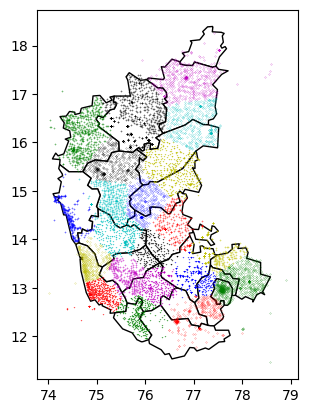

In [298]:
op=k_means(21)
#print(op[3][0])
Long21=[]
Latt21=[]
Long20=[]
Latt20=[]
Long19=[]
Latt19=[]
Long18=[]
Latt18=[]
Long17=[]
Latt17=[]
Long16=[]
Latt16=[]
Long15=[]
Latt15=[]
Long14=[]
Latt14=[]
Long12=[]
Latt12=[]
Long13=[]
Latt13=[]
Long1=[]
Latt1=[]
Long2=[]
Latt2=[]
Long3=[]
Latt3=[]
Latt4=[]
Long4=[]
Long5=[]
Latt5=[]
Long6=[]
Latt6=[]
Long7=[]
Latt7=[]
Long8=[]
Latt8=[]
Long9=[]
Latt9=[]
Latt10=[]
Long10=[]
Latt11=[]
Long11=[]
#print(op[3][0],op[3][1],sep='\n\n\n\n')
for a in range(21):
    if a==0:
        for el in op[3][a]:
            Long1.append(el[1])
            Latt1.append(el[0])
    elif a==1:
        for el in op[3][a]:
            Long2.append(el[1])
            Latt2.append(el[0])
    elif a==2:
        for el in op[3][a]:
            Long3.append(el[1])
            Latt3.append(el[0])
    elif a==3:
        for el in op[3][a]:
            Long4.append(el[1])
            Latt4.append(el[0])
    elif a==4:
        for el in op[3][a]:
            Long5.append(el[1])
            Latt5.append(el[0])
    elif a==5:
        for el in op[3][a]:
            Long6.append(el[1])
            Latt6.append(el[0])
    elif a==6:
        for el in op[3][a]:
            Long7.append(el[1])
            Latt7.append(el[0])
    elif a==7:
        for el in op[3][a]:
            Long8.append(el[1])
            Latt8.append(el[0])
    elif a==8:
        for el in op[3][a]:
            Long9.append(el[1])
            Latt9.append(el[0])
    elif a==9:
        for el in op[3][a]:
            Long10.append(el[1])
            Latt10.append(el[0])
    elif a==10:
        for el in op[3][a]:
            Long11.append(el[1])
            Latt11.append(el[0])
    elif a==11:
        for el in op[3][a]:
            Long12.append(el[1])
            Latt12.append(el[0])
    elif a==12:
        for el in op[3][a]:
            Long13.append(el[1])
            Latt13.append(el[0])
    elif a==13:
        for el in op[3][a]:
            Long14.append(el[1])
            Latt14.append(el[0])
    elif a==14:
        for el in op[3][a]:
            Long15.append(el[1])
            Latt15.append(el[0])
    elif a==15:
        for el in op[3][a]:
            Long16.append(el[1])
            Latt16.append(el[0])
    elif a==16:
        for el in op[3][a]:
            Long17.append(el[1])
            Latt17.append(el[0])
    elif a==17:
        for el in op[3][a]:
            Long18.append(el[1])
            Latt18.append(el[0])
    elif a==18:
        for el in op[3][a]:
            Long19.append(el[1])
            Latt19.append(el[0])
    elif a==19:
        for el in op[3][a]:
            Long20.append(el[1])
            Latt20.append(el[0])
    elif a==20:
        for el in op[3][a]:
            Long21.append(el[1])
            Latt21.append(el[0])

#print(riyal)
#import matplotlib.pyplot as plt #Need to do this last part :(:(:(
#print(df.head())
#df_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LONGITUDE,df.LATITUDE))
#print(df_geo)
im = plt.imread('KTaka_map_1.png')
map_df = gpd.read_file('india_ds.shp')
axis=map_df[map_df["STATE"] == 'KARNATAKA'].plot(color='white',edgecolor='black')
#plt.figure(figsize=(7,12))
#plt.plot(df["LONGITUDE"],df['LATITUDE'],'r*',markersize=0.5,zorder=2)
plt.plot(Long1,Latt1,'ro',markersize=0.15)
plt.plot(Long2,Latt2,'bo',markersize=0.15)
plt.plot(Long3,Latt3,'yo',markersize=0.15)
plt.plot(Long4,Latt4,'go',markersize=0.15)
plt.plot(Long5,Latt5,'co',markersize=0.15)
plt.plot(Long6,Latt6,'ko',markersize=0.15)
plt.plot(Long7,Latt7,'mo',markersize=0.15)
plt.plot(Long8,Latt8,'cs',markersize=0.15)
plt.plot(Long9,Latt9,'rs',markersize=0.15)
plt.plot(Long10,Latt10,'bs',markersize=0.15)
plt.plot(Long11,Latt11,'ks',markersize=0.15)
plt.plot(Long12,Latt12,'gs',markersize=0.15)
plt.plot(Long13,Latt13,'ys',markersize=0.15)
plt.plot(Long14,Latt14,'ms',markersize=0.15)
plt.plot(Long15,Latt15,'c^',markersize=0.15)
plt.plot(Long16,Latt16,'r^',markersize=0.15)
plt.plot(Long17,Latt17,'g^',markersize=0.15)
plt.plot(Long18,Latt18,'m^',markersize=0.15)
plt.plot(Long19,Latt19,'k^',markersize=0.15)
plt.plot(Long20,Latt20,'y^',markersize=0.15)
plt.plot(Long21,Latt21,'b^',markersize=0.15)
plt.show()